In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.base import clone

from sklearn.metrics import (
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score, 
    accuracy_score, 
    roc_curve, 
    precision_recall_curve,
    confusion_matrix,
    auc)

from hyperopt import hp, fmin, tpe, Trials

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### Section 1 Helper Functions

In [2]:
def show_stats(df):
    dtypes = df.dtypes
    nulls = df.isnull().sum()
    unique_count = df.apply(lambda x: x.nunique())
    columns = ['dtypes', 'null count', 'unique count']
    df_ = pd.concat([dtypes, nulls, unique_count], axis=1)
    df_.columns = columns
    return df_

In [3]:
def plot_feature_importance(X, y):
    rf_mod = RandomForestClassifier()
    rf_mod.fit(X, y)
    feature_importance = rf_mod.feature_importances_
    feats = pd.DataFrame(zip(X.columns, feature_importance), columns=['feature', 'importance'])
    feats = feats.sort_values('importance', ascending=False)
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feats, color='lightblue', ax=ax)
    ax.set_title('Feature Importance')

In [4]:
def score_model(X_train, y_train, model, folds=3, scoring='roc_auc'):

    scores = cross_val_score(model, X_train, y_train, cv=folds, scoring=scoring, n_jobs=4, error_score='raise')
    return np.mean(scores), np.std(scores)

In [5]:
# returns a fitted estimator. for use with models with few parameters
def grid_search(X_train, y_train, model, param_grid, folds=10, scoring='roc_auc'):
    grid_mod = GridSearchCV(estimator=model, 
                            param_grid=param_grid, 
                            scoring=scoring, 
                            n_jobs=4, 
                            cv=folds,
                            verbose=1,
                            refit=False)
    
    grid_mod.fit(X_train, y_train)

    print(f'for {model.__class__.__name__}')
    print('Best Score: ', grid_mod.best_score_)
    print('Best Params: ', grid_mod.best_params_)
    return grid_mod.best_params_

### Section 2 Load and prep the data

#### 2.1 Load

In [6]:
# load data
train_data_path = 'Twibot-20/data_creation/train_final_dataset.json'
test_data_path = 'Twibot-20/data_creation/test_final_dataset.json'
train_df = pd.read_json(train_data_path)
test_df = pd.read_json(test_data_path)

train_df.set_index('ID', drop=True, inplace=True)
test_df.set_index('ID', drop=True, inplace=True)

print('Train shape: ', train_df.shape)
print('Test shape: ', test_df.shape)
print(train_df.columns)
train_df.sample(5)

Train shape:  (9395, 35)
Test shape:  (1176, 35)
Index(['profile', 'tweet', 'neighbor', 'domain', 'label', 'nn_signal',
       'lang_count', 'tweet_min_len', 'tweet_max_len', 'tweet_av_len',
       'tweet_len_std', 'user_name_len', 'screen_name_len', 'user_name_chars',
       'protected', 'verified', 'has_url', 'followers_count', 'friends_count',
       'favourites_count', 'days_old', 'listed_count', 'statuses_count',
       'description_len', 'sentiment', 'similarity', 'num_mentions',
       'num_links', 'retweet', 'num_tweets', 'topic_dist', 'topic_skew',
       'topic_kurtosis', 'topic_gini', 'topic_std'],
      dtype='object')


,profile,tweet,neighbor,domain,label,nn_signal,lang_count,tweet_min_len,tweet_max_len,tweet_av_len,tweet_len_std,user_name_len,screen_name_len,user_name_chars,protected,verified,has_url,followers_count,friends_count,favourites_count,days_old,listed_count,statuses_count,description_len,sentiment,similarity,num_mentions,num_links,retweet,num_tweets,topic_dist,topic_skew,topic_kurtosis,topic_gini,topic_std
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
19766553,"{'id': '19766553 ', 'id_str': '19766553 ', 'na...",[RT @RealCarlVernon: Sky News Australia. The o...,"{'following': ['34889027', '31181655', '229152...",[Sports],1,0.601374,2,9,269,99.710000,49.056762,16,11,14,0,0,0,270,2800,607,4838,10,3169,17,Positive,0.672998,1.095000,0.265000,0.490000,200,"[0.35000000000000003, 0.18, 0.8250000000000001...",0.125925,-1.381601,0.440149,0.279778
4512493167,"{'id': '4512493167 ', 'id_str': '4512493167 ',...",[RT @EmergencyPeace: @REnlightenment A first c...,"{'following': ['119895130', '3535080623', '361...",[Entertainment],1,0.877822,1,24,149,119.742574,31.246910,15,11,12,0,0,1,357,1098,496,2326,1,332,84,Positive,0.695473,1.742574,0.386139,0.792079,101,"[0.45544554460000003, 0.2574257426, 0.33663366...",0.059376,-1.370740,0.397500,0.281997
814386998140174336,"{'id': '814386998140174336 ', 'id_str': '81438...",[Retweet if you can relate! ❤️ https://t.co/QH...,"{'following': ['1518269647', '2830906441', '74...",[Politics],1,0.908346,2,21,304,210.655000,65.813418,20,16,12,0,0,1,1160,2247,48,1948,13,994,48,Positive,0.824281,0.225000,0.690000,0.125000,200,"[0.225, 0.59, 0.6900000000000001, 0.66, 0.215,...",-0.015493,-1.293744,0.355746,0.299179
21316253,"{'id': '21316253 ', 'id_str': '21316253 ', 'na...","[Trump on Fox suggests that some cops ""choke"" ...","{'following': ['198967539', '1216872631', '279...","[Entertainment, Sports]",0,0.152446,2,39,305,125.205000,55.674437,12,12,8,0,1,1,238020,5703,84,4818,4306,175981,26,Negative,0.737871,0.200000,0.525000,0.025000,200,"[0.35000000000000003, 0.14, 0.54, 0.265, 0.18,...",0.091613,-1.163250,0.351376,0.284668
617205854,"{'id': '617205854 ', 'id_str': '617205854 ', '...",[@MourningWood2\nYa I think it's ok and marry ...,"{'following': ['23375688', '189934379', '20999...",[Entertainment],0,0.513824,2,2,141,65.064815,35.298797,11,11,6,0,0,0,3,30,3,3597,0,108,33,Positive,0.705980,0.259259,0.157407,0.009259,108,"[0.7777777778, 0.046296296300000005, 0.7407407...",0.032173,-1.346677,0.403164,0.283150


#### 2.2 Drop columns and display stats

In [7]:
train_df.drop(['profile', 'tweet', 'neighbor', 'domain', 'topic_dist'], axis=1, inplace=True)
test_df.drop(['profile', 'tweet', 'neighbor', 'domain', 'topic_dist'], axis=1, inplace=True)
train_df.shape

(9395, 30)

In [8]:
print('train_df')
display(show_stats(train_df))
print('test_df')
show_stats(test_df)

train_df


,dtypes,null count,unique count
label,int64,0,2
nn_signal,float64,0,9331
lang_count,int64,0,17
tweet_min_len,int64,0,151
tweet_max_len,int64,0,548
tweet_av_len,float64,0,8659
tweet_len_std,float64,0,9250
user_name_len,int64,0,50
screen_name_len,int64,0,14
user_name_chars,int64,0,31


test_df


,dtypes,null count,unique count
label,int64,0,2
nn_signal,float64,0,1172
lang_count,int64,0,17
tweet_min_len,int64,0,95
tweet_max_len,int64,0,274
tweet_av_len,float64,0,1159
tweet_len_std,float64,0,1161
user_name_len,int64,0,46
screen_name_len,int64,0,13
user_name_chars,int64,0,25


In [9]:
# all nulls are from tweets with 0 or 1 tweet or users who had no words in the tweets after vectorization we will fill all nulls qith a zero
train_df.fillna(0, inplace=True)
test_df.fillna(0, inplace=True)

#### 2.3 Convert sentament feature to integer values

In [10]:
sentement_dict = {
    'Positive': 1,
    'Negative': 0
}

train_df['sentiment'] = train_df['sentiment'].apply(lambda x: sentement_dict[x])
test_df['sentiment'] = test_df['sentiment'].apply(lambda x: sentement_dict[x])

#### 2.4 Separate into X and y

In [11]:
X_train = train_df.drop(['label'], axis=1)
y_train = train_df['label']

X_test = test_df.drop(['label'], axis=1)
y_test = test_df['label']

#### 2.5 Feature Importance

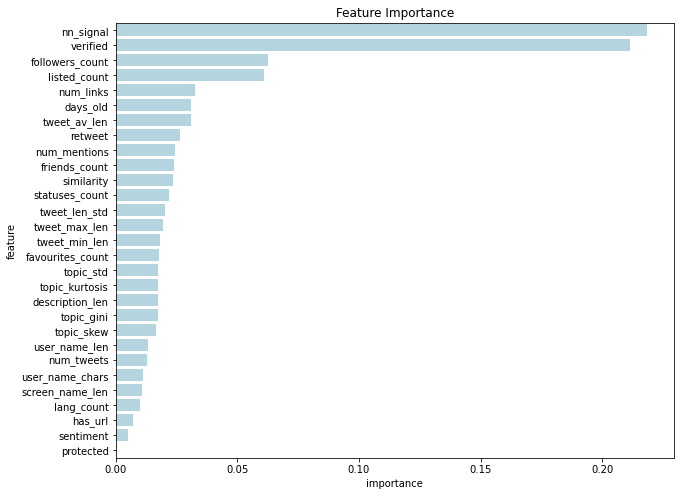

In [12]:
plot_feature_importance(X_train, y_train)

#### 2.6 Scale with StandardScaler

In [13]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Section 3 Modeling

### 3.1 Initial Baseline Model

In [14]:
baseline_model = LogisticRegression()
score_model(X_train, y_train, baseline_model, folds=10)

(0.942757589911665, 0.008520851798185482)

#### 3.2 Tuning Multiple Models

#### 3.2.1 Linear Models

Logistic Regression

In [15]:
# train / gridsearch Logistic Regression
lr_model = LogisticRegression()

lr_param_grid = {'C': [.001, .01, .1, 1, 10]}
best_lr_params = grid_search(X_train, y_train, lr_model, lr_param_grid)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
for LogisticRegression
Best Score:  0.9429540428651026
Best Params:  {'C': 0.1}


In [16]:
best_lr_model = LogisticRegression(**best_lr_params)

SGDClassifier

In [17]:


sgd_param_grid = {'l1_ratio': hp.uniform('l1_ratio', 0, 1),
                  'learning_rate': hp.choice(
                      'learning_rate', [{
                          'type': 'optimal',
                          'alpha': hp.lognormal('alpha', 0, .5)
                      },
                      {
                          'type': 'invscaling',
                          'power_t': hp.normal('power_t', 0, 1)
                      }]
                  ),
                  'eta0': hp.lognormal('eta0', 0, 1)}

def sgd_objective(search_space):
    # im setting the loss function to 'modified_huber' loss as other losses create a 
    # logistic regression and linear svm model while others are for regression. 
    # modified_huber is also robust to outliers
    l1_ratio = search_space['l1_ratio']
    learning_rate = search_space['learning_rate']['type']
    eta0 = search_space['eta0']
    if 'alpha' in search_space['learning_rate']:
        learning_param = search_space['learning_rate']['alpha']
        sgd_model = SGDClassifier(loss='modified_huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  alpha=learning_param,
                                  eta0=eta0)
    else:
        learning_param = search_space['learning_rate']['power_t']
        sgd_model = SGDClassifier(loss='modified_huber', 
                                  penalty='elasticnet', 
                                  l1_ratio=l1_ratio,
                                  learning_rate=learning_rate,
                                  power_t=learning_param,
                                  eta0=eta0)


    score, _ = score_model(X_train, y_train, sgd_model)
    return -1 * np.mean(score)

In [18]:
trials = Trials()
max_evals = 500
sgd_best_params = fmin(fn=sgd_objective, space=sgd_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
sgd_best_params

100%|██████████| 500/500 [02:10<00:00,  3.83trial/s, best loss: -0.9428806881743416]


{'eta0': 0.18831013798653412,
 'l1_ratio': 0.0225343475284234,
 'learning_rate': 1,
 'power_t': 0.7230010110092647}

In [19]:
l1_ratio = sgd_best_params['l1_ratio']
learning_rate = 'optimal' if sgd_best_params['learning_rate'] == 0 else 'invscaling'
eta0 = sgd_best_params['eta0']

if learning_rate == 'optimal':
    alpha = sgd_best_params['alpha']
    best_sgd_model = SGDClassifier(loss='modified_huber', 
                                penalty='elasticnet', 
                                learning_rate=learning_rate, 
                                l1_ratio=l1_ratio, 
                                eta0=eta0,
                                alpha=alpha)
else:
    power_t = sgd_best_params['power_t']
    best_sgd_model = SGDClassifier(loss='modified_huber', 
                                penalty='elasticnet', 
                                learning_rate=learning_rate, 
                                l1_ratio=l1_ratio, 
                                eta0=eta0,
                                power_t=power_t)

#### 3.2.2 Tree Based Models

LightGBM

In [20]:


lgbm_param_grid = {'reg_alpha': hp.lognormal('reg_alpha', 0, .5),
                   'reg_lambda': hp.lognormal('reg_lambda', 0, .5),
                   'subsample': hp.uniform('subsample', 0, 1),
                   'num_leaves': hp.quniform('num_leaves', 10, 100, 1),
                   'max_depth': hp.quniform('max_depth', 1, 10, 1),
                   'n_estimators': hp.quniform('n_estimators', 50, 100, 1),
                   'learning_rate': hp.loguniform('learning_rate', -3, 0)}

def lgbm_objective(search_space):
    reg_alpha = search_space['reg_alpha']
    reg_lambda = search_space['reg_lambda']
    subsample = search_space['subsample']
    num_leaves = search_space['num_leaves']
    max_depth = search_space['max_depth']
    n_estimators = search_space['n_estimators']
    learning_rate = search_space['learning_rate']
    
    lgbm_model = LGBMClassifier(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate)

    score, _ = score_model(X_train, y_train, lgbm_model)
    return -1 * np.mean(score)

In [21]:
trials = Trials()
max_evals = 500
lgbm_best_params = fmin(fn=lgbm_objective, space=lgbm_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
lgbm_best_params

100%|██████████| 500/500 [07:27<00:00,  1.12trial/s, best loss: -0.9442521647474152]


{'learning_rate': 0.10624230907735359,
 'max_depth': 8.0,
 'n_estimators': 74.0,
 'num_leaves': 10.0,
 'reg_alpha': 1.3912479124236743,
 'reg_lambda': 0.15718030705801095,
 'subsample': 0.049584130036664925}

In [22]:

reg_alpha = lgbm_best_params['reg_alpha']
reg_lambda = lgbm_best_params['reg_lambda']
subsample = lgbm_best_params['subsample']
num_leaves = lgbm_best_params['num_leaves']
max_depth = lgbm_best_params['max_depth']
n_estimators = lgbm_best_params['n_estimators']
learning_rate = lgbm_best_params['learning_rate']

best_lgbm_model = LGBMClassifier(reg_alpha=reg_alpha,
                                reg_lambda=reg_lambda,
                                subsample=subsample,
                                num_leaves=int(num_leaves),
                                max_depth=int(max_depth),
                                n_estimators=int(n_estimators),
                                learning_rate=learning_rate)

Random Forest

In [23]:

rf_param_grid = {'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
                 'max_depth': hp.quniform('max_depth', 2, 20, 1),
                 'max_features': hp.choice('max_features', ['auto', 'sqrt']),
                 'min_samples_split': hp.quniform('min_samples_split', 2, 5, 1),
                 'min_samples_leaf': hp.quniform('min_samples_leaf', 1, 5, 1)}

def rf_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    max_features = search_space['max_features']
    min_samples_split = search_space['min_samples_split']
    min_samples_leaf = search_space['min_samples_leaf']

    rf_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                      max_depth=int(max_depth),
                                      max_features=max_features,
                                      min_samples_split=int(min_samples_split),
                                      min_samples_leaf=int(min_samples_leaf))

    score, _ = score_model(X_train, y_train, rf_model)
    return -1 * np.mean(score)

In [24]:
trials = Trials()
max_evals = 200
rf_best_params = fmin(fn=rf_objective, space=rf_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
rf_best_params

100%|██████████| 200/200 [30:10<00:00,  9.05s/trial, best loss: -0.9417933972561419]


{'max_depth': 13.0,
 'max_features': 0,
 'min_samples_leaf': 4.0,
 'min_samples_split': 2.0,
 'n_estimators': 486.0}

In [25]:
n_estimators = rf_best_params['n_estimators']
max_depth = rf_best_params['max_depth']
max_features = rf_best_params['max_features']
min_samples_split = rf_best_params['min_samples_split']
min_samples_leaf = rf_best_params['min_samples_leaf']

best_rf_model = RandomForestClassifier(n_estimators=int(n_estimators),
                                       max_depth=int(max_depth),
                                       max_features= 'auto' if max_features == 0 else 'sqrt',
                                       min_samples_split=int(min_samples_split),
                                       min_samples_leaf=int(min_samples_leaf))

Adaboost

In [26]:

ada_param_grid = {'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
                  'max_depth': hp.quniform('max_depth', 1, 3, 1),
                  'min_samples_split': hp.quniform('min_samples_split', 2, 10, 1),
                  'learning_rate': hp.lognormal('learning_rate', 0, 1)}

def ada_objective(search_space):
    n_estimators = search_space['n_estimators']
    max_depth = search_space['max_depth']
    min_samples_split = search_space['min_samples_split']
    learning_rate = search_space['learning_rate']

    ada_model = AdaBoostClassifier(n_estimators=int(n_estimators),
                                   learning_rate=learning_rate,
                                   base_estimator=DecisionTreeClassifier(max_depth=int(max_depth),
                                                                         min_samples_split=int(min_samples_split)))

    score, _ = score_model(X_train, y_train, ada_model)
    return -1 * np.mean(score)

In [27]:
trials = Trials()
max_evals = 200
ada_best_params = fmin(fn=ada_objective, space=ada_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
ada_best_params

100%|██████████| 200/200 [25:49<00:00,  7.75s/trial, best loss: -0.9446945881538232]


{'learning_rate': 0.03433636587315747,
 'max_depth': 2.0,
 'min_samples_split': 9.0,
 'n_estimators': 196.0}

In [28]:
n_estimators = ada_best_params['n_estimators']
max_depth = ada_best_params['max_depth']
min_samples_split = ada_best_params['min_samples_split']
learning_rate = ada_best_params['learning_rate']

best_ada_model = AdaBoostClassifier(n_estimators=int(n_estimators),
                                    learning_rate=learning_rate,
                                    base_estimator=DecisionTreeClassifier(max_depth=int(max_depth),
                                                                          min_samples_split=int(min_samples_split)))

#### 3.2.3 Support Vector Machine

SVC

In [29]:


svc_param_grid = {'C': hp.loguniform('C', -5, 4),
                  'kernal': hp.choice('kernal', [{
                      'type': 'linear'
                  },
                  {
                      'type': 'rbf',
                      'gamma': hp.loguniform('gamma', -9, 3)
                  }])}

def svc_objective(search_space):
    C = search_space['C']
    kernal = search_space['kernal']['type']
    if kernal == 'rbf':
        gamma = search_space['kernal']['gamma']
        svc_model = SVC(C=C,
                        kernel=kernal,
                        gamma=gamma,
                        probability=True)
    else:
        svc_model = SVC(C=C,
                        kernel=kernal,
                        probability=True)

    score, _ = score_model(X_train, y_train, svc_model)
    return -1 * np.mean(score)

In [30]:
trials = Trials()
max_evals = 100
svc_best_params = fmin(fn=svc_objective, space=svc_param_grid, algo=tpe.suggest, trials=trials, max_evals=max_evals)
svc_best_params

100%|██████████| 100/100 [52:52<00:00, 31.73s/trial, best loss: -0.942191365105781]  


{'C': 0.2969529403683625, 'kernal': 0}

In [33]:
C = svc_best_params['C']
kernel = 'linear' if svc_best_params['kernal'] == 0 else 'rbf'
if kernel == 'rbf':
    gamma = svc_best_params['gamma']
    best_svc_model = SVC(C=C,
                         kernel=kernel,
                         gamma=gamma,
                         probability=True)
else:
    best_svc_model = SVC(C=C,
                         kernel=kernel,
                         probability=True)

#### 3.3 Model Ensembling

#### 3.3.1 Voting Classifier

In [34]:
vote_classifier = VotingClassifier(estimators=[('LogisticRegression', best_lr_model), 
                                               ('SGDClassifier', best_sgd_model), 
                                               ('LGBMClassifier', best_lgbm_model), 
                                               ('RandomForestClassifier', best_rf_model), 
                                               ('AdaBoostClassifier', best_ada_model), 
                                               ('SVC', best_svc_model)],
                                   voting='soft')

In [35]:
mean, std = score_model(X_train, y_train, vote_classifier, folds=5)
print('mean roc_auc score: ', mean, ' std: ', std)

mean roc_auc score:  0.9448402027974279  std:  0.003942056082434834


#### 3.3.2 Stacking Classifier

In [36]:
stack_classifier = StackingClassifier(estimators=[('LogisticRegression', best_lr_model), 
                                                  ('SGDClassifier', best_sgd_model), 
                                                  ('LGBMClassifier', best_lgbm_model), 
                                                  ('RandomForestClassifier', best_rf_model), 
                                                  ('AdaBoostClassifier', best_ada_model), 
                                                  ('SVC', best_svc_model)],
                                      final_estimator=LogisticRegression())

In [37]:
mean, std = score_model(X_train, y_train, stack_classifier, folds=5)
print('mean roc_auc score: ', mean, ' std: ', std)

mean roc_auc score:  0.94528882086074  std:  0.0039799592526809455


### Section 4 Results and Analysis

#### 4.1 Model testing function

In [38]:
def test_model(X_train, y_train, X_test, y_test, model):
    mod = clone(model)
    mod.fit(X_train, y_train)
    y_probs = mod.predict_proba(X_test)
    y_preds = mod.predict(X_test)
    results = pd.Series(index=['roc_auc', 'accuracy', 'precision', 'recall', 'f1'], dtype='float64')
    results.loc['roc_auc'] = roc_auc_score(y_test, y_probs[:, 1])
    results.loc['accuracy'] = accuracy_score(y_test, y_preds)
    results.loc['precision'] = precision_score(y_test, y_preds)
    results.loc['recall'] = recall_score(y_test, y_preds)
    results.loc['f1'] = f1_score(y_test, y_preds, average='macro')

    conf_matrix = confusion_matrix(y_test, y_preds)

    print('Metrics:')
    display(results)

    print('\nConfusion Matrix:\n')
    print('                  Predicted Positive   Predicted Negative')
    print('Actual Positive |        {tp:>3}        |        {fn:>3}        |'.format(tp=conf_matrix[0, 0], fn=conf_matrix[0, 1]))
    print('Actual Negative |        {fp:>3}        |        {tn:>3}        |'.format(fp=conf_matrix[1, 0], tn=conf_matrix[1, 1]))
    print()

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    print('\nRoc Auc curve:')
    fpr, tpr, _ = roc_curve(y_test, y_probs[:, 1])
    sns.lineplot(x=fpr, y=tpr, ax=ax[0], label=f'Roc Auc score={auc(fpr, tpr)}')
    ax[0].plot([0, 1],[0, 1], linestyle='--')
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver Operating Characteristic')

    pre, rec, _ = precision_recall_curve(y_test, y_probs[:, 1])
    sns.lineplot(x=rec, y=pre, ax=ax[1])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall Curve')

    plt.tight_layout()
    plt.show()

#### 4.2 Model comparison on test set

#### 4.2.1 Basic Logistic Regression

Metrics:


roc_auc      0.918991
accuracy     0.856293
precision    0.843840
recall       0.907550
f1           0.853188
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        418        |        109        |
Actual Negative |         60        |        589        |


Roc Auc curve:


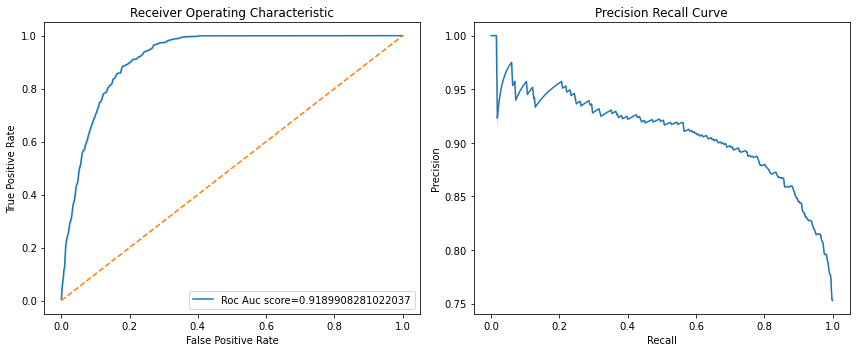

In [39]:
test_model(X_train, y_train, X_test, y_test, LogisticRegression())

#### 4.2.2 Voting Classifier

Metrics:


roc_auc      0.922590
accuracy     0.857143
precision    0.844063
recall       0.909091
f1           0.854020
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        418        |        109        |
Actual Negative |         59        |        590        |


Roc Auc curve:


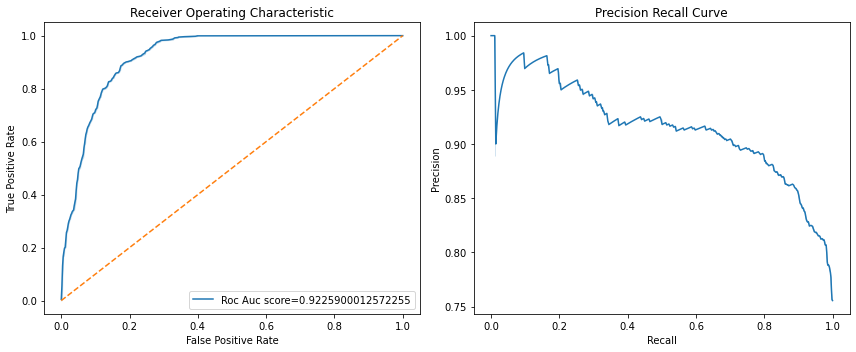

In [40]:
test_model(X_train, y_train, X_test, y_test, vote_classifier)

#### 4.2.3 Stacking Classifier

Metrics:


roc_auc      0.923868
accuracy     0.857143
precision    0.846043
recall       0.906009
f1           0.854167
dtype: float64


Confusion Matrix:

                  Predicted Positive   Predicted Negative
Actual Positive |        420        |        107        |
Actual Negative |         61        |        588        |


Roc Auc curve:


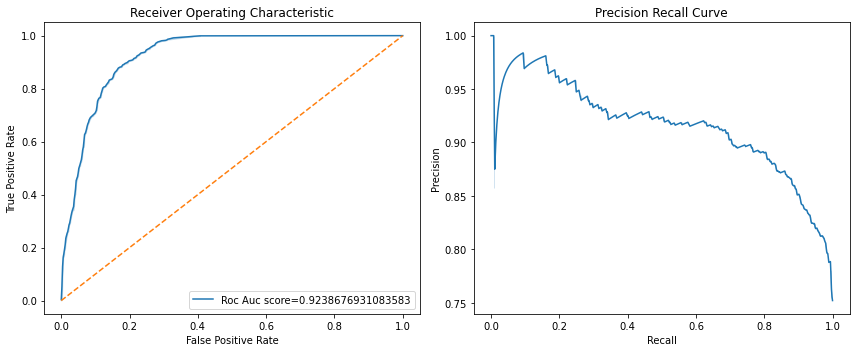

In [41]:
test_model(X_train, y_train, X_test, y_test, stack_classifier)